## Credit Card Fraud Detection

## Understanding the Dataset 

Dataset - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


> Credits: Kaggle 


__ Problem Statement __

- To recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.


__ Performance Metric __

* log-loss
* Binary Confusion Matrix

__ Mapping the real world problem to an ML problem __

- It is a binary classification Problem.



In [14]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

print('done')

done


In [15]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Data Analysis 

## Checking Null Values

In [42]:
data.isnull().values.any()

False

## Distribution of data points among output class

Text(0, 0.5, 'Frequency')

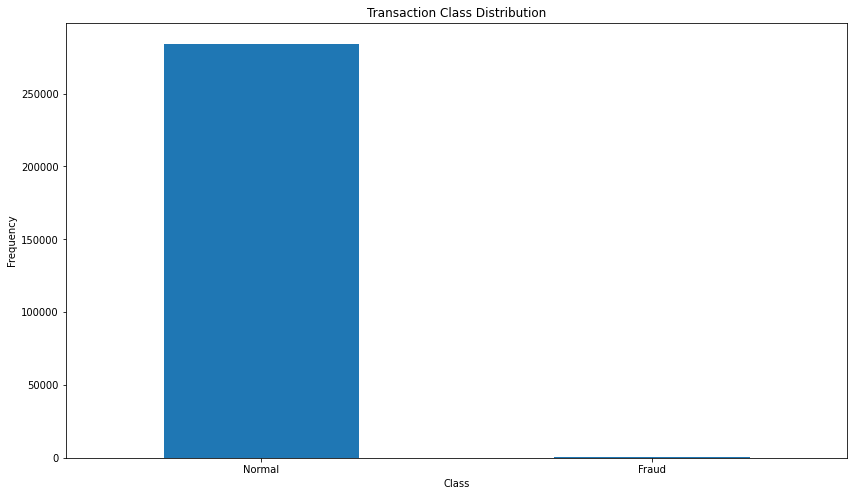

In [55]:

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

## Obervations 
1. Normal Transactions is greater than 250k and fraud is very less.
2. We can easily Conclude that this is Highly imbalanced dataset.

In [43]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [44]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [45]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [46]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Transactions with respect to amount by class

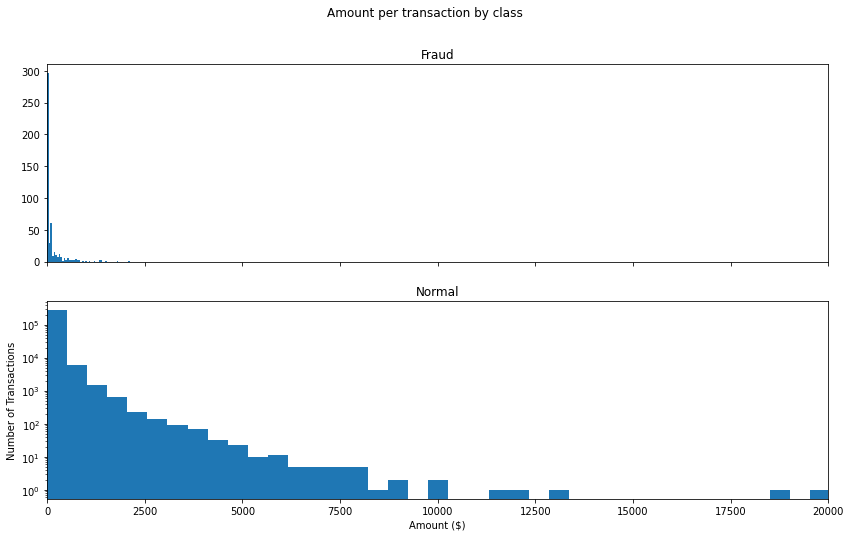

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

## Observations
1. Transaction for fraud with respect to the amount is very Less.
2. Transaction for normal with respect to the amount is high

## Transactions with respect time of transaction vs amount by class.

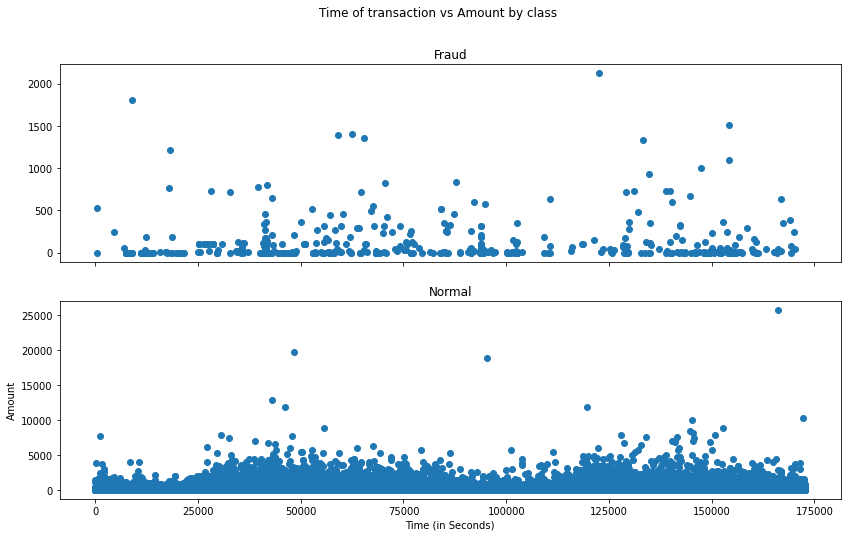

In [49]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Observations
1. There is lot of overlapping the data points so cant make much sense out of it.

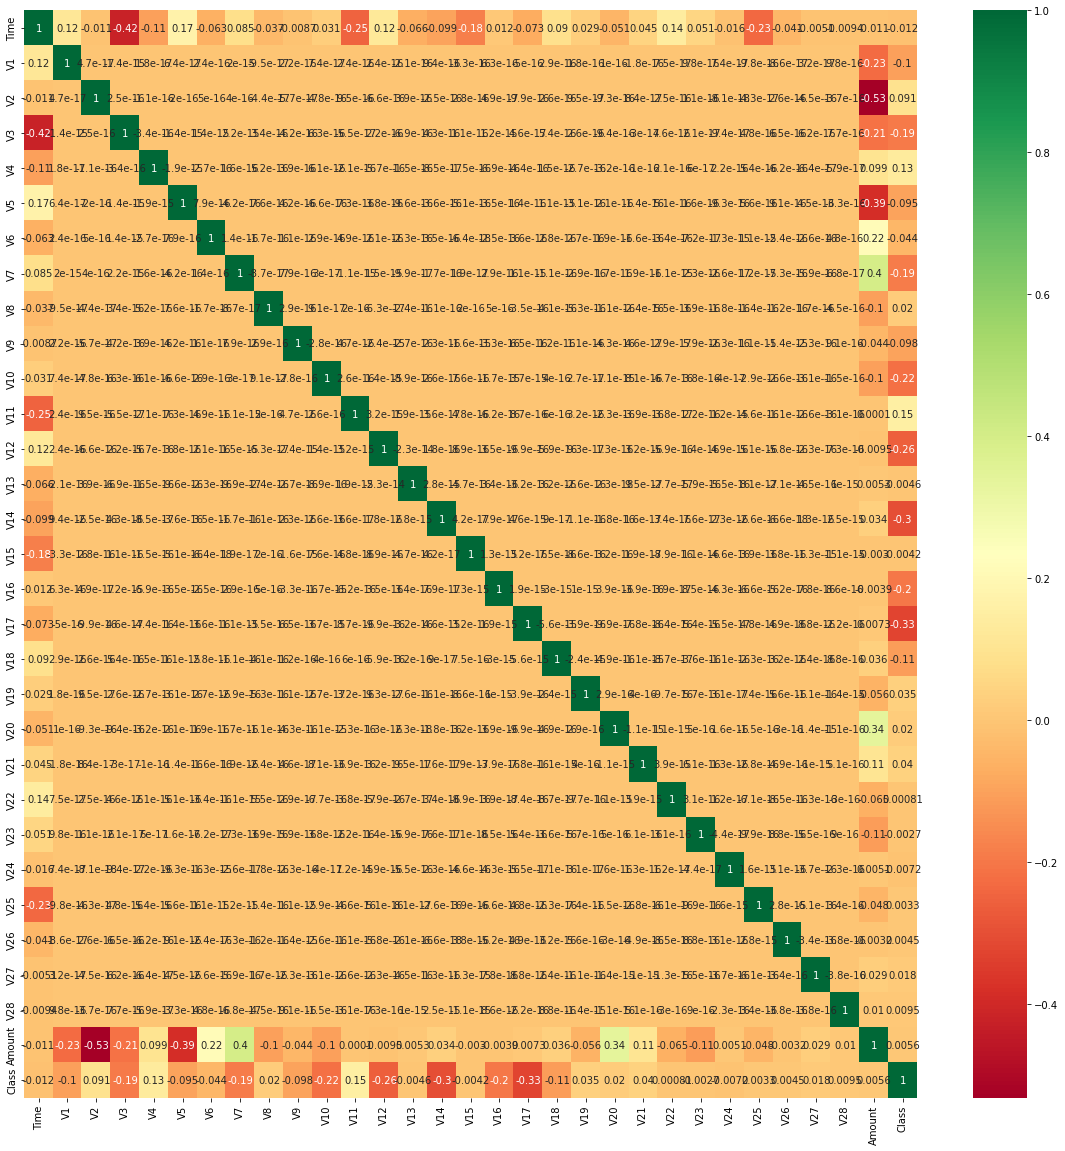

In [52]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Train and Test Dataset Construction using undersampling

In [26]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

number_records_fraud = len (data[data.Class==1])


fraud_indices = np.array (data[data.Class==1].index)
normal_indices = np.array (data[data.Class==0].index)


random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False )

under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])


under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc [:, under_sample_data.columns != 'Class'];
y_undersample = under_sample_data.iloc [:, under_sample_data.columns == 'Class'];


from sklearn.model_selection import train_test_split
#X_train_old, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.3, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split (X_undersample,y_undersample, test_size = 0.3, random_state = 0)



In [27]:
count_classes = pd.value_counts(y_train['Class'], sort = True)
print(count_classes)

count_classes = pd.value_counts(y_test['Class'], sort = True)
print(count_classes)

1    345
0    343
Name: Class, dtype: int64
0    149
1    147
Name: Class, dtype: int64


## Distribution of data points among output classes of train and test data

Text(0, 0.5, 'Frequency')

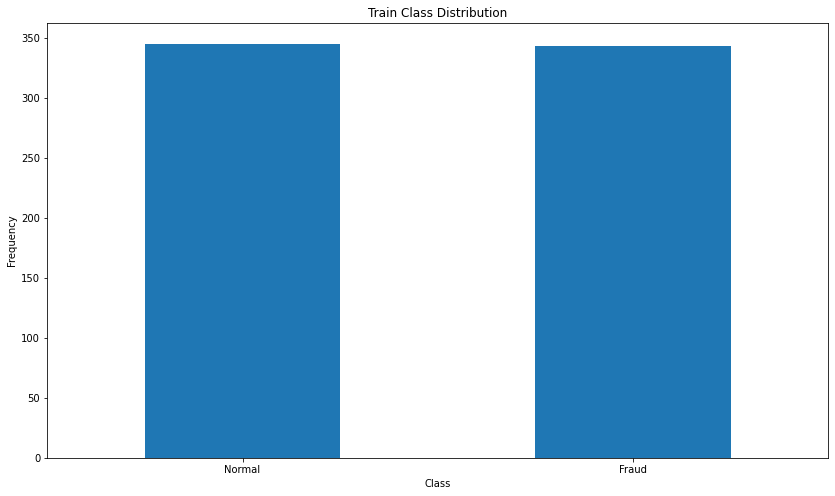

In [53]:


count_classes = pd.value_counts(y_train['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Train Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

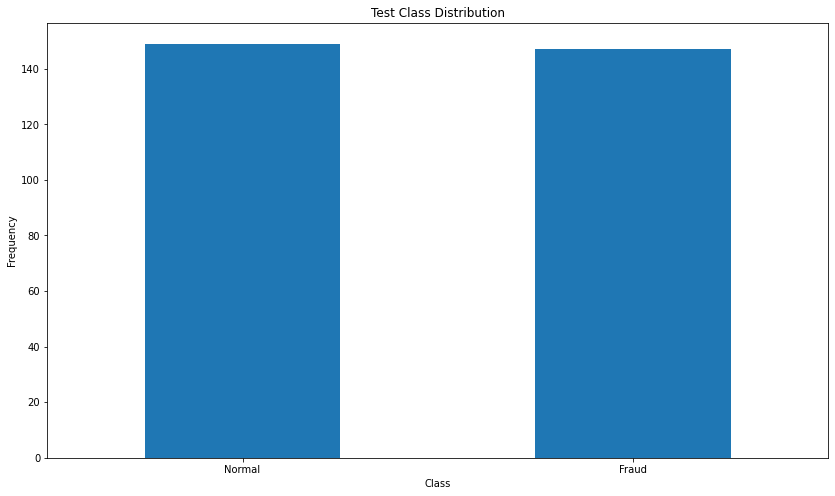

In [54]:
count_classes = pd.value_counts(y_test['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Test Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

## Observations
1. Number of Normal and Fraud Transactions Are Almost Equal.
2. Now we have balanced dataset.

In [30]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (688, 30)
Number of data points in test data : (296, 30)


In [56]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Machine Learning Models

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8551604150925879


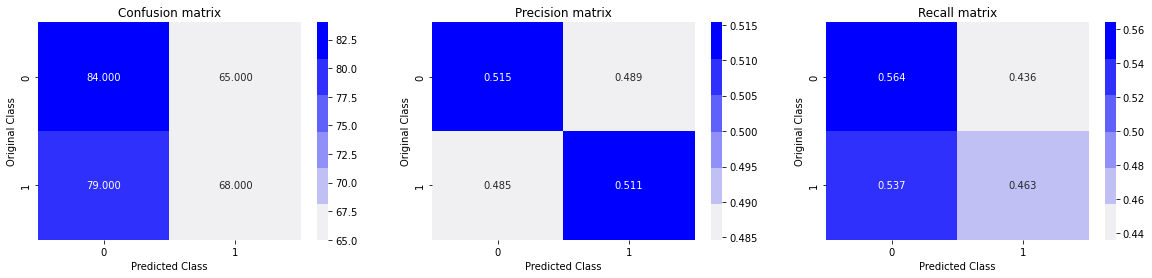

In [37]:
import numpy as np
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6931707651075326
For values of alpha =  0.0001 The log loss is: 0.6931707651075326
For values of alpha =  0.001 The log loss is: 0.6931707651075326
For values of alpha =  0.01 The log loss is: 0.6931707651075326
For values of alpha =  0.1 The log loss is: 0.6931707651075326
For values of alpha =  1 The log loss is: 0.6931707651075326
For values of alpha =  10 The log loss is: 0.6878332617748486


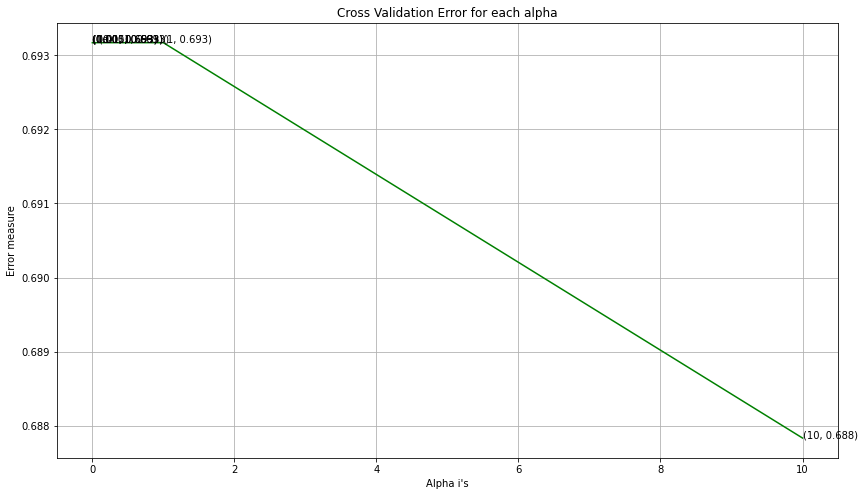

For values of best alpha =  10 The train log loss is: 0.682963400552309
For values of best alpha =  10 The test log loss is: 0.6878332617748486
Total number of data points : 296


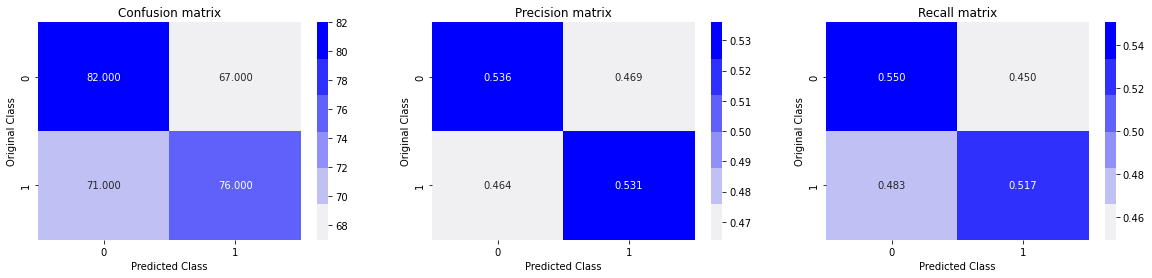

In [38]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Observations
1. Log Loss of Logistic Regresion is 0.68 is less than worst case log loss(0.85) of random model.
2. Precision or class l (fraud) is 0.53 and recall is 0.51.


## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6931707651075326
For values of alpha =  0.0001 The log loss is: 0.6931707651075326
For values of alpha =  0.001 The log loss is: 0.6931707651075326
For values of alpha =  0.01 The log loss is: 0.6931707651075326
For values of alpha =  0.1 The log loss is: 0.6931707651075326
For values of alpha =  1 The log loss is: 0.6931707651075326
For values of alpha =  10 The log loss is: 0.6931707651075326


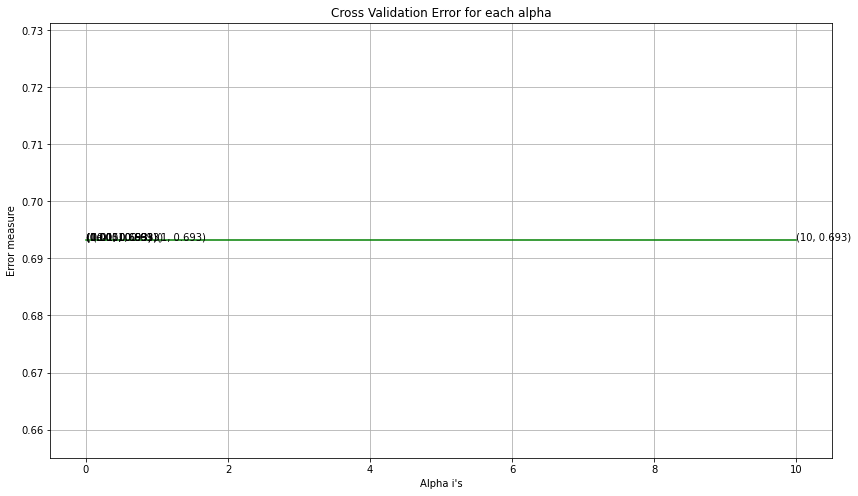

For values of best alpha =  1e-05 The train log loss is: 0.6931429557257294
For values of best alpha =  1e-05 The test log loss is: 0.6931707651075326
Total number of data points : 296


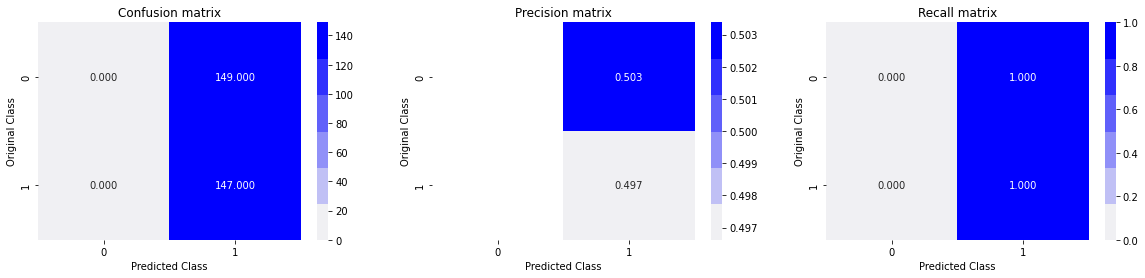

In [39]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Observations
1. Log Loss of Linear SVM is 0.69 is less than worst case log loss(0.85) of random model.
2. Precision or class l (fraud) is 0.49 and recall is 100%.


## XGBoost 

In [40]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67636	valid-logloss:0.67757
[10]	train-logloss:0.53890	valid-logloss:0.55093
[20]	train-logloss:0.44025	valid-logloss:0.46082
[30]	train-logloss:0.36659	valid-logloss:0.39636
[40]	train-logloss:0.31000	valid-logloss:0.34664
[50]	train-logloss:0.26573	valid-logloss:0.30847
[60]	train-logloss:0.23056	valid-logloss:0.27986
[70]	train-logloss:0.20248	valid-logloss:0.25696
[80]	train-logloss:0.17895	valid-logloss:0.23869
[90]	train-logloss:0.15946	valid-logloss:0.22448
[100]	train-logloss:0.14329	valid-logloss:0.21374
[110]	train-logloss:0.12963	valid-logloss:0.20568
[120]	train-logloss:0.11816	valid-logloss:0.19883
[130]	train-logloss:0.10806	valid-logloss:0.19397
[140]	train-logloss:0.09902	valid-logloss:0.18968
[150]	train-logloss:0.09140	valid-logloss:0.18586
[160]	train-logloss:0.08450	valid-logloss:0.18271
[170]	train-logloss:0.07857	valid-logloss:0.17983
[180]	train-logloss:0.07296	valid-logloss:0.17772
[190]	train-logloss:0.06731	valid-logloss:0.17552
[200]	train

Total number of data points : 296


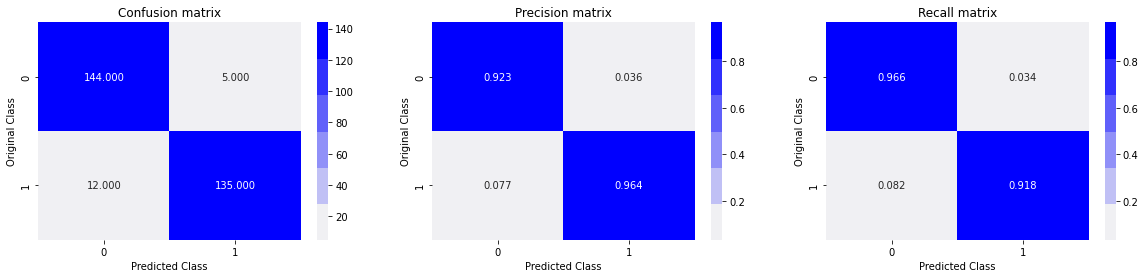

In [41]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Observations
1. Log Loss of XGBoost is 0.16 is less than worst case log loss(0.85) of random model.
2. Precision for class label 1(fraud) is 96.4% and recall is 91.8 % ,which is very good.
3. Precision for class label 0(normal) is 92.3% and recall is 96.6 % ,which is very good.

## Final Conclusions 
1. XGboost has log loss 0.16 less than Linear SVM 0.69 and Logistic Regression 0.68.
2. Overall XGboost is the best ML model to recognize fraudulent credit card transactions.
3. We can also reduce this loss by increasing the sample size(oversampling) or use deep learning algorithms however at the cost of computational expense.